# Brainstorm notebook
Nils Bruin, Alexa van der Waall, April 9, 2020

We refer to other worksheets for the description of the fixed-time SIQR model implemented below. In this worksheet, we just try to highlight a few of the features and brainstorm ideas on what interesting questions we might be able to answer. Changes from earlier versions:
 * time scale is now configurable, so the dynamics can be adjusted in a way that correspond to "per day"
 * a coefficient has been introduced to scale compliance to "self isolation" for people who turn symptomatic

## Assumptions:
 * testing can detect the disease in any infected person, regardless of symptoms
 * infectivity is purely a function of age of infection; not whether the individual is symptomatic
 * symptomatic population is not explicitly tracked. Onset of symptoms is just used as an input into whether one moves into self-isolation (i.e., into the "quarantined" bins).
 * the quarantined bins presently double as "reported" cases as well. In that sense, the model is good for "partially visible" epidemics: you can make the epidemic entirely invisible by setting no interventions: no self isolation, no testing (and hence no contact tracing, because there is no-one to trace)
 * quarantine time just follows actual disease duration (which is assumed fixed), so someone who moves into quarantine half way through the disease spends half the time in quarantine of someone who is quarantined right at the point of infection.
 * there is an implicit assumption that quarantine is perfect: individuals in quarantine do not infect. In particular this means that quarantined individuals are removed from an epidynamical perspective. We're just tracking them because it's an interesting statistic, and it's probably the number that policy should take into account.
 
## Quantities we might want to optimize:
 * Total number of cases, i.e., $r_\infty=1-s_\infty$. Assuming a fixed CFR, minimizing (or at least capping) the total case number corresponds to minimizing (or capping) fatalities.
 * Total number of active cases at any one time i.e. $M=\max_t(I(t)+Q(t))$. This measure should be proportional to peak resource usage, so that's the number that needs to be capped to stay within the capacity of the health care system.
 
If we can attach cost functions to each of the interventions $C_\text{quar}$ (proportion of quarantining due to onset of symptoms), $C_\text{contact}$ (physical distancing: 1 means none at all; 0 means perfect distancing), $C_\text{test}$ (surveillance testing throughout the population), $C_\text{trace}$ (contact tracing of people quarantined due to symptom onset or testing), we could minimize costs for given objectives and/or determine feasibility of certain objectives given a particular budget.

If this is really of interest, we should probably keep a few more statistics of contact tracing to account for its actual cost: it will depend on how many people need to be traced at a particular point in time. That information is currently computed, but not stored.

## Math caveats:
 * Because contact tracing integrates back in time, I think there's potentially an issue with overestimating its effect: with very high quarantining rates, I think it's possible that there are so many traces, that there's a non-negligible expected proportion of people who are double-traced. This is currently not accounted for. At the same time, double-infections are also not accounted for; which in a discrete-time system is in principle an issue. But with a large $N$ that should disappear.
 * Indeed, we see that for larger $N$ the epidemic usually comes out at lower $r_\infty$. THis is to be expected: numerically, the critical part of our simulation is around the peak of the epidemic, where the epicurve is concave. So, one would indeed expect lower order methods to overestimate it.

In [1]:
import numpy as np
from numpy import exp, abs, log, floor
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import reduce
from operator import mul
def prod(L): return reduce(mul,L)

#I need a function with compact support, and choosing a differentiable seemed nice
#this is the simplest I could think of; it is not otherwise motivated for the
#distributions that I need it for.
def compact_support_function(min=0,max=1,shape=1,skew=1,scale=1):
    """Returns an infinitely differentiable function with compact support
    
    Returns an appropriate transform of exp(1/(x(x-1))).
    Parameters:
      [min,max] : interval on which function is non-zero
      shape     : (>0) larger values make the peak sharper
      skew      : (>0) Values <1 mean skew to left, values >1 mean skew to right
      scale     : maximum value.
    """
    interval_length=max-min
    scale=scale/exp(-4*shape)
    def f(x):
        t=(x-min)/interval_length
        if 0<t<1:
            ts=t**skew
            return scale*exp(shape/ts/(ts-1))
        else:
            return 0
    return f

class simulation:
    def __init__(self,N,beta_dist,q_dist,I0,policy,time_scale=1.0):
        
        #conversion between real time and discrete time step number
        self.N = N
        Tfactor = N/time_scale
        self.Tfactor = Tfactor
        
        #discretize distributions
        beta=[quad(beta_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        symptom_onset_prop=[quad(q_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        q=[]
        symptomatic_prop=[]
        running_total=0
        for i in range(N):
            q.append(symptom_onset_prop[i]/(1-running_total))
            running_total+=symptom_onset_prop[i]
            symptomatic_prop.append(running_total)
        
        #sanity check that conditional probabilities match total
        assert abs((1-sum(symptom_onset_prop)-prod((1-c) for c in q)))< 10e-5
        
        #bookkeeping
        self.beta_dist=beta_dist
        self.q_dist=q_dist
        self.beta=beta
        self.symptom_onset_prop=symptom_onset_prop
        self.symptomatic_prop=symptomatic_prop
        self.q=q
        self._s=[]
        self._r=[]
        self._I=[]
        self._Q=[]
        self._betaprime=[]
        self.I0=I0
        self.N=N
        self.policy=policy
        self._policy=[]
        self.time_scale=time_scale

        
    #conversion function between real time and step number (t is real time; T is step number)
    def T_from_t(self,t):
        return int(floor(t*self.Tfactor))
    def t_from_T(self,T):
        return T/self.Tfactor
    def time_step_list(self,t0,t1):
        return np.arange(t0,t1,1/self.Tfactor)
        
    #access functions: our initial conditions are, for T<0, a proportion I0 of the
    #population uniformly distributed over the I_a, with no quarantining or infections happening.
    def s(self,T):
        return self._s[T] if T>=0 else 1-self.I0
    def r(self,T):
        return self._r[T] if T>=0 else 0
    def I(self,T):
        return self._I[T] if T>=0 else tuple(self.I0/self.N for i in range(self.N))
    def Q(self,T):
        return self._Q[T] if T>=0 else tuple(0 for i in range(self.N))
    def betaprime(self,T):
        return self._betaprime[T] if T>=0 else tuple(0 for i in range(self.N))
    
    #this is the actual step. It computes step T+1 from step T. It's an internal routine.
    def step_after(self,T):
        N=self.N
        
        #we should only get called if T+1 is really the next step to be computed.
        if len(self._s) != T+1:
            raise RuntimeError("length mismatch")
        policyT=self.policy(self,self.t_from_T(T))
        self._policy.append(policyT)
        C_quar,C_contact,C_test,C_trace=policyT
        Ctst=C_test/self.Tfactor
        s=self.s(T)
        r=self.r(T)
        betaprime=[s*self.beta[i]*C_contact for i in range(self.N)]
        IT=self.I(T)
        QT=self.Q(T)
        Inew=sum([d*i for d,i in zip(betaprime,IT)])
        Qnew=[(C_quar*c+Ctst)*i for c,i in zip(self.q,IT)]
        
        #this is the loop where we compute the quarantining contribution
        #of contact tracing: we work from the oldest infections forward,
        #so that we can take into account the derived infections from
        #the ones added earlier in the loop.
        for dT in range(self.N-1,-1,-1):
            for age in range(dT,self.N):
                Qnew[dT]+=self.betaprime(T-dT)[age-dT]*Qnew[age]*C_trace
        IT=[i-q for i,q in zip(IT,Qnew)]
        QT=[v+q for v,q in zip(QT,Qnew)]
        s-=Inew
        r+=IT[-1]+QT[-1]
        self._s.append(s)
        self._r.append(r)
        self._I.append([Inew]+IT[:-1])
        self._Q.append([0]+QT[:-1])
        self._betaprime.append(betaprime)
        
    def compute(self,t):
        """Ensures that the simulation is computed to time t (i.e., t*N steps)
        """
        Tend=self.T_from_t(t)
        for T in range(len(self._s)-1,Tend):
            self.step_after(T)

    def disease_plots(self):
        """produces plots illustrating the characteristics of the configured disease
        """
        N=self.N
        Tfactor=self.Tfactor
        stride=1/Tfactor
        time_scale=self.time_scale
        t_range=np.arange(0,time_scale,time_scale/100)

        fig, ((ax1,ax4),(ax2,ax3)) = plt.subplots(2,2)
        ax4.get_shared_y_axes().join(ax1, ax4)
        fig.set_size_inches(16,10)
        fvals=[self.beta_dist(a) for a in t_range]
        ticks=np.arange(stride/2,time_scale,stride)
        R0=sum(self.beta)
        ax1.bar(ticks,[i*Tfactor for i in self.beta],alpha=0.5,width=stride,label="infectivity integrated\n over intervals")
        ax1.plot(t_range,fvals,color="black",label="infectivity density")
        ax1.set_title("Infectivity (area=R0)")
        ax1.set_xlabel("infection age")
        ax1.set_ylabel("infection rate")
        R0_label_y=max(fvals)/10
        R0_label_x=time_scale/10
        ax1.text(R0_label_x,R0_label_y,"R0 = {:3.3}".format(R0))
        ax1.legend(loc="upper right")

        fvals=[self.q_dist(a) for a in t_range]
        ax2.plot(t_range,fvals,color="black",label="density")
        ax2.bar(ticks,[i*Tfactor for i in self.symptom_onset_prop],alpha=0.5,width=stride,label="integrated")
        ax2.bar(ticks,[i*Tfactor for i in self.q],alpha=0.2,color="red",width=stride,label="conditional rates")
        ax2.set_title("Symptom distribution")
        ax2.legend()
        ax2.set_xlabel("infection age")
        ax2.set_ylabel("symptom rate")

        ax3.set_title("asymptomatic infected proportion")
        ax3.set_xlabel("infection age")
        ax3.set_ylabel("asymptomatic proportion")
        ax3.text(R0_label_x,0.1,"asymptomatic proportion = {:3.3}".format(1-self.symptomatic_prop[-1]))
        ax3.bar(ticks,[1-p for p in self.symptomatic_prop],alpha=0.5,width=stride)

        q_adjusted_infection_coefficient=[(1-p)*c for p,c in zip(self.symptomatic_prop,self.beta)]
        R0q=sum(q_adjusted_infection_coefficient)
        ax4.set_title("Quarantine-adjusted infectivity (area=R0q)")
        ax4.set_xlabel("infection age")
        ax4.set_ylabel("infection rate")
        ax4.text(R0_label_x,R0_label_y,"R0q = {:3.3}".format(R0q))
        ax4.bar(ticks,[c*Tfactor for c in q_adjusted_infection_coefficient],alpha=0.5,width=stride)
        return fig
        
    def time_plots(self,t):
        """Produces time series plots that show the simulation for time (0...t)
        """
        self.compute(t)
        T=int(t*self.N/self.time_scale)
        s=self._s[:T]
        r=self._r[:T]
        I=self._I[:T]
        Q=self._Q[:T]
        fig, (ax2,ax1,ax3) = plt.subplots(1,3)
        fig.set_size_inches(16,5)
        times=[a/self.N*self.time_scale for a in range(T)]
        ax1.set_title("active cases")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,[sum(i) for i in I],label="infected unquarantined")
        ax1.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax1.plot(times,[sum(i) for i in Q],label="quarantined")
        ax1.legend(loc="upper right")
        ax2.set_title("susceptible/removed")
        ax2.set_xlabel("time")
        ax2.set_ylabel("proportion of population")
        ax2.plot(times,s,label="susceptible")
        ax2.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax2.plot(times,r,label="removed")
        ax2.legend()
        ax2.set_ylim([0,1])
        ax3.set_title("policy")
        ax3.set_ylim([0,1.01])
        ax3.set_xlabel("time")
        ax3.set_ylabel("measure intensity")
        policy=self._policy[:T]        
        ax3.plot(times,[a[0] for a in policy],label="self-quarantining")
        ax3.plot(times,[1-a[1] for a in policy],label="physical distancing")
        ax3.plot(times,[a[2] for a in policy], label="surveilance testing")
        ax3.plot(times,[a[3] for a in policy],label="contact tracing")
        ax3.legend()
        return fig

## Disease profile:
Below, we consider a disease with a duration of 21 days and a sizeable $R_0$. We set symptom onset distribution to something relatively moderate, and relatively slow. This limits the effectiveness of self_isolation on symptom onset, as we can see.

We give a graphical representation of the disease characteristics, the reference (unmitigated) epicurve and the epicurve with perfect self-isolation.

One idea would be to consider three diseases, with fixed symptom onset distributions, and front loaded infectivity (Frontvid), mid-loaded infectivity (Midvid) and backloaded infectivity (Backvid) -- the disease here (and Covid) would be mostly Frontvid and compare the impact of interventions, as analyzed below, for these different diseases; probably arriving at the obvious conclusions (but now to some degree quantitatively verified)

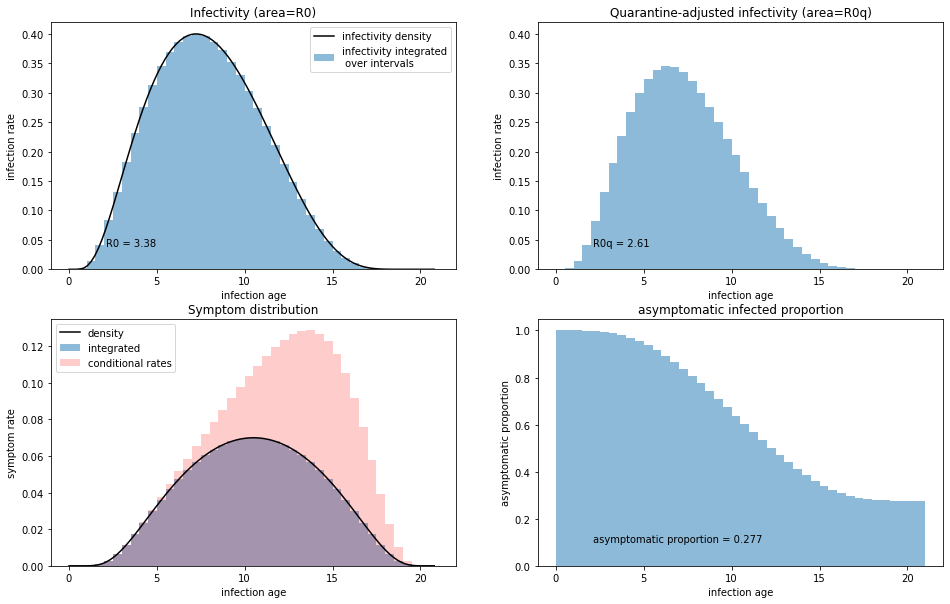

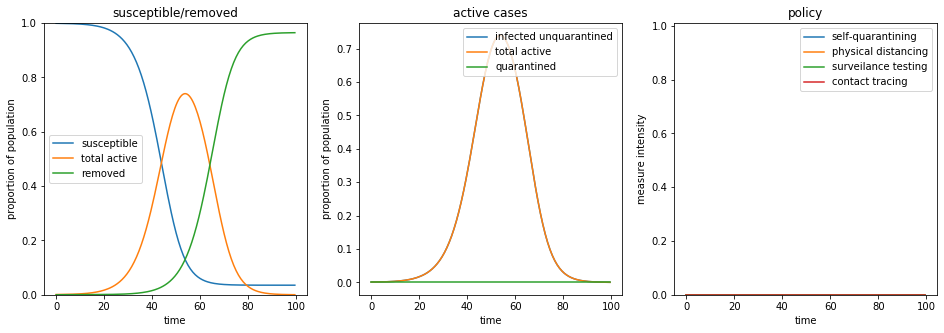

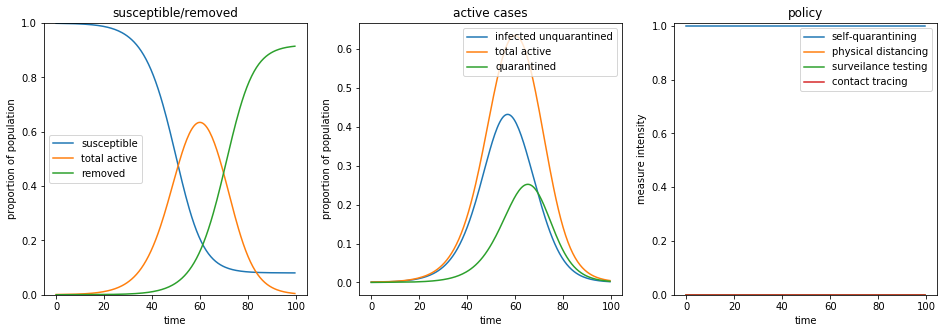

In [2]:
beta_dist=compact_support_function(0,21,scale=0.4,shape=1,skew=0.65)
q_dist=compact_support_function(0,21,scale=0.07,skew=1,shape=0.5)
        
S=simulation(42,beta_dist,q_dist,0.001,policy=lambda S,t:(0,1,0,0),time_scale=21)
_=S.disease_plots()
_=S.time_plots(100)
S=simulation(42,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,0),time_scale=21)
_=S.time_plots(100)

## Time-dependent policies

We can define policies as a function of the current state (for instance, the current active reported cases (the population in quarantine), or if you want to make it a little more reactive, perhaps the newly quarantined cases -- that would require a little amendment of the code to keep track of this figure, Below we pulse physical distancing. Obvious observations:
 * this policy will only cap max resource usage $M$, we'll end up at herd immunity level for $r_\infty$ (but probably not overshoot!)
 * we should probably limit the number on/off switches. So we should probably turn off at a lower level that where we turn on
 * there are some optimization questions there to minimize time to herd immunity under capped $M$, and limiting the total time spent with distancing measures in force.
 * as an illustration, we turn of self-quarantining near the end of the epidemic, to show that the resource usage peak isn't so bad at that point, but we of course to end up with a higher total number of cases.
 * we could probably reduce the level of distancing measures later on without much penalty. Since the cost of distancing is probably not linear in $1-C_\text{contact}$, this could be a real gain.

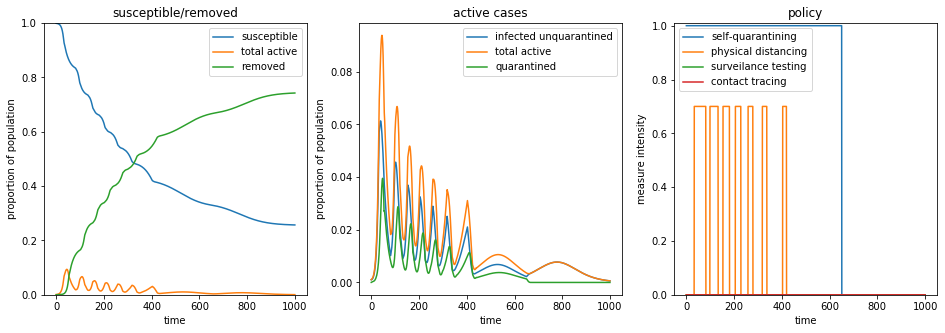

In [3]:
onoff=0
def policy(sim,t):
    global onoff
    C_quar=1 #let's assume self-quaranting measures in place
    C_contact=1
    C_test=0
    C_trace=0
    Qtot=sum(sim.Q(sim.T_from_t(t)))
    if onoff == 0 and Qtot > 0.01:
        onoff = 1
    elif onoff == 1 and Qtot < 0.008:
        onoff = 0
    C_contact= 0.3 if onoff else 1
    if t>650:
        C_quar=0
    return (C_quar,C_contact,C_test,C_trace)    
        
S=simulation(60,beta_dist,q_dist,0.001,policy=policy,time_scale=21)
_=S.time_plots(1000)

## Evaluation of combined effects of interventions
We run simulations for different combinations of levels of interventions and estimate different characteristics based on it (total cases $r_\infty$ and max number of active cases $M$). Note that normally, the parameter "testing" is defined as "proportion of the population tested per time unit". In the plots below this has been rescaled by a factor `test_scaling`: testing the whole population every day is clearly unrealistic and is so far into epidemic-killing measures that it would be a waste of plot space to include it in the picture. So, in the pictures below, 1 on the testing scale means testing `test_scaling` (say, 10%) of the population every day. 

In [4]:
Z_contact_trace=[]
Z_test_trace=[]

M_contact_trace=[]
M_test_trace=[]

test_scaling=0.1

xlist=np.linspace(0,1.0,10)
ylist=xlist.copy()
X,Y=np.meshgrid(xlist, ylist)

N_sim=20
t_inf=200

Z_contact_test=[]
M_contact_test=[]
for j in ylist:
    W=[]
    m=[]
    for i in xlist:
        val=simulation(N_sim,beta_dist,q_dist,0.0001,policy=lambda sim,t: (1,1-i,j*test_scaling,0),time_scale=21)
        val.compute(t_inf)
        W.append(val._r[-1])
        m.append(max(sum(q)+sum(i) for q,i in zip(val._Q,val._I)))
    Z_contact_test.append(W)
    M_contact_test.append(m)

Z_contact_trace=[]
M_contact_trace=[]
for j in ylist:
    W=[]
    m=[]
    for i in xlist:
        val=simulation(N_sim,beta_dist,q_dist,0.0001,policy=lambda sim,t: (1,1-i,0,j),time_scale=21)
        val.compute(t_inf)
        W.append(val._r[-1])
        m.append(max(sum(q)+sum(i) for q,i in zip(val._Q,val._I)))
    Z_contact_trace.append(W)
    M_contact_trace.append(m)

Z_test_trace=[]
M_test_trace=[]
for j in ylist:
    W=[]
    m=[]
    for i in xlist:
        val=simulation(N_sim,beta_dist,q_dist,0.0001,policy=lambda sim,t: (1,1,i*test_scaling,j),time_scale=21)
        val.compute(t_inf)
        W.append(val._r[-1])
        m.append(max(sum(q)+sum(i) for q,i in zip(val._Q,val._I)))
    Z_test_trace.append(W)
    M_test_trace.append(m)

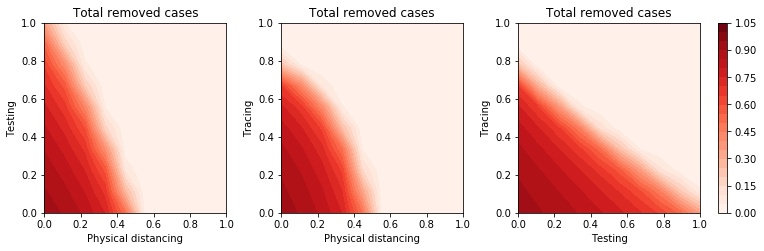

In [5]:
# Make the three contour plots
# Add a colourbar as a fourth plot.
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

levels=np.arange(0,1.1,0.05)
fig, axes = plt.subplots(1,4)
ax1=axes[0]
ax2=axes[1]
ax3=axes[2]
cax=axes[3]
fig.set_size_inches(16,3.5)
fig.subplots_adjust(wspace = 0.3)
#
CS1=ax1.contourf(X,Y,Z_contact_test, levels=levels, cmap="Reds")
#fig.colorbar(CS)
#ax1.clabel(CS, inline=1, fontsize=10)
ax1.set_title('Total removed cases')
ax1.set_xlabel('Physical distancing')
ax1.set_ylabel('Testing')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
#
CS2=ax2.contourf(X,Y,Z_contact_trace, levels=levels,cmap="Reds")
ax2.set_title('Total removed cases')
ax2.set_xlabel('Physical distancing')
ax2.set_ylabel('Tracing')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
#
CS3=ax3.contourf(X,Y,Z_test_trace, levels=levels,cmap="Reds")
ax3.set_title('Total removed cases')
ax3.set_xlabel('Testing')
ax3.set_ylabel('Tracing')
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
#
ip = InsetPosition(ax3, [1.1,0,0.05,1]) 
cax.set_axes_locator(ip)
_=fig.colorbar(CS1, cax=cax, ax=[ax1,ax2,ax3])

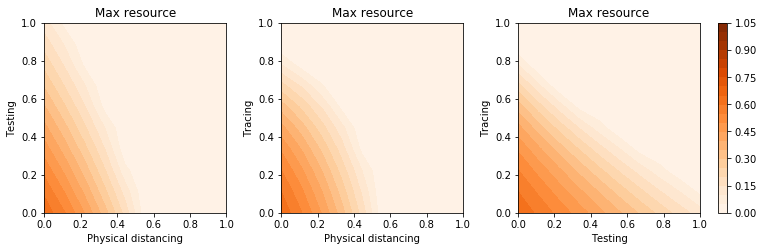

In [6]:
# Make the three contour plots
# Add a colourbar as a fourth plot.
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

levels=np.arange(0,1.1,0.05)
fig, axes = plt.subplots(1,4)
ax1=axes[0]
ax2=axes[1]
ax3=axes[2]
cax=axes[3]
fig.set_size_inches(16,3.5)
fig.subplots_adjust(wspace = 0.3)
#
CS1=ax1.contourf(X,Y,M_contact_test, levels=levels,cmap="Oranges")
#fig.colorbar(CS)
#ax1.clabel(CS, inline=1, fontsize=10)
ax1.set_title('Max resource')
ax1.set_xlabel('Physical distancing')
ax1.set_ylabel('Testing')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
#
CS2=ax2.contourf(X,Y,M_contact_trace, levels=levels,cmap="Oranges")
ax2.set_title('Max resource')
ax2.set_xlabel('Physical distancing')
ax2.set_ylabel('Tracing')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
#
CS3=ax3.contourf(X,Y,M_test_trace, levels=levels,cmap="Oranges")
ax3.set_title('Max resource')
ax3.set_xlabel('Testing')
ax3.set_ylabel('Tracing')
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
#
ip = InsetPosition(ax3, [1.1,0,0.05,1]) 
cax.set_axes_locator(ip)
_=fig.colorbar(CS1, cax=cax, ax=[ax1,ax2,ax3])